# Введение в анализ данных (первый семестр)


data from: https://www.kaggle.com/decide-soluciones/air-quality-madrid

**Задача:** Изучить и проанализировать погодные показатели в городе Мадрид(уровень загрязнения воздуха). Предсказать уровень загрязнение на ближайшее время. Данные собраны за 2001-2018 года.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

import math
import itertools
import os
import pandas as pd
import numpy as np
import operator
from itertools import product
from collections import defaultdict
from scipy.stats import boxcox, probplot
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import missingno as msno
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Посмотрим на данные, которые у нас есть

Данные о метостанциях, которые собирают показатели:

In [2]:
with pd.HDFStore('madrid.h5') as data:
    master = data['master']
    
master.head()

,id,name,address,lon,lat,elevation
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
1,28079008,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,670
2,28079011,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,708
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693
4,28079017,Villaverde,C/. Juan Peñalver,-3.713322,40.347139,604


Пример данных, собранных одной метеостанцией

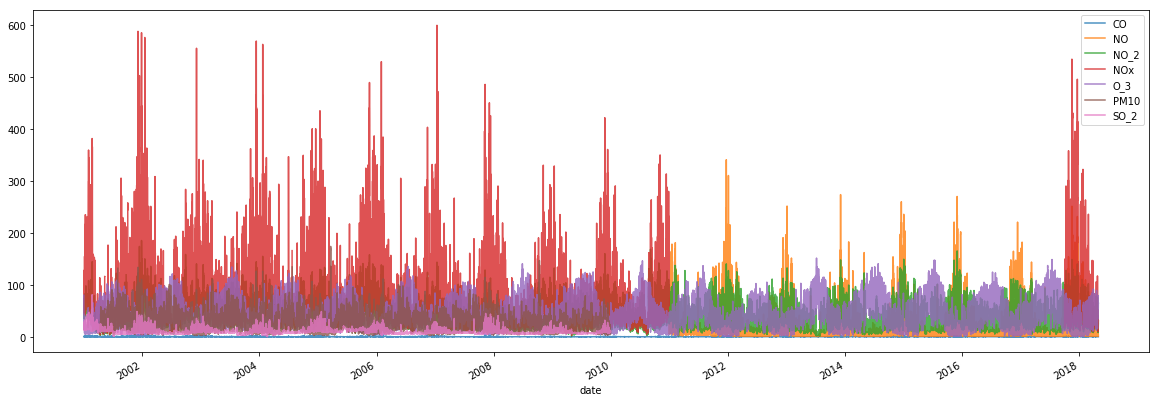

In [3]:
with pd.HDFStore('madrid.h5') as data:
    test = data['28079016']

test.rolling(window=12).mean().plot(figsize=(20, 7), alpha=0.8)
plt.show()

Признаки-показатели, которые присутствуют в данных:

**SO_2**: sulphur dioxide level measured in μg/m³. High levels of sulphur dioxide can produce irritation in the skin and membranes, and worsen asthma or heart diseases in sensitive groups.

**CO**: carbon monoxide level measured in mg/m³. Carbon monoxide poisoning involves headaches, dizziness and confusion in short exposures and can result in loss of consciousness, arrhythmias, seizures or even death in the long term.

**NO**: nitric oxide level measured in μg/m³. This is a highly corrosive gas generated among others by motor vehicles and fuel burning processes.

**NO_2**: nitrogen dioxide level measured in μg/m³. Long-term exposure is a cause of chronic lung diseases, and are harmful for the vegetation.

**PM25**: particles smaller than 2.5 μm level measured in μg/m³. The size of these particles allow them to penetrate into the gas exchange regions of the lungs (alveolus) and even enter the arteries. Long-term exposure is proven to be related to low birth weight and high blood pressure in newborn babies.

**PM10**: particles smaller than 10 μm. Even though the cannot penetrate the alveolus, they can still penetrate through the lungs and affect other organs. Long term exposure can result in lung cancer and cardiovascular complications.

**NOx**: nitrous oxides level measured in μg/m³. Affect the human respiratory system worsening asthma or other diseases, and are responsible of the yellowish-brown color of photochemical smog.

**O_3**: ozone level measured in μg/m³. High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive groups or outdoor workers.

**TOL**: toluene (methylbenzene) level measured in μg/m³. Long-term exposure to this substance (present in tobacco smkoke as well) can result in kidney complications or permanent brain damage.

**BEN**: benzene level measured in μg/m³. Benzene is a eye and skin irritant, and long exposures may result in several types of cancer, leukaemia and anaemias. Benzene is considered a group 1 carcinogenic to humans by the IARC.

**EBE**: ethylbenzene level measured in μg/m³. Long term exposure can cause hearing or kidney problems and the IARC has concluded that long-term exposure can produce cancer.

**MXY**: m-xylene level measured in μg/m³. Xylenes can affect not only air but also water and soil, and a long exposure to high levels of xylenes can result in diseases affecting the liver, kidney and nervous system (especially memory and affected stimulus reaction).

**PXY**: p-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.

**OXY**: o-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.

**TCH**: total hydrocarbons level measured in mg/m³. This group of substances can be responsible of different blood, immune system, liver, spleen, kidneys or lung diseases.

**CH4**: methane level measured in mg/m³. This gas is an asphyxiant, which displaces the oxygen animals need to breath. Displaced oxygen can result in dizzinnes, weakness, nausea and loss of coordination.

**NMHC**: non-methane hydrocarbons (volatile organic compounds) level measured in mg/m³. Long exposure to some of these substances can result in damage to the liver, kidney, and central nervous system. Some of them are suspected to cause cancer in humans.


In [4]:
partials = []

with pd.HDFStore('madrid.h5') as data:
    stations = [k[1:] for k in data.keys() if k != '/master']
    for station in stations:
        df = data[station]
        df['station'] = station
        partials.append(df)
            
df = pd.concat(partials, sort=False).sort_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808224 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 18 columns):
CO         float64
NO_2       float64
NOx        float64
O_3        float64
PM10       float64
PM25       float64
SO_2       float64
station    object
NO         float64
BEN        float64
EBE        float64
MXY        float64
NMHC       float64
OXY        float64
PXY        float64
TCH        float64
TOL        float64
CH4        float64
dtypes: float64(17), object(1)
memory usage: 552.0+ MB


In [5]:
df.head()

,CO,NO_2,NOx,O_3,PM10,PM25,SO_2,station,NO,BEN,EBE,MXY,NMHC,OXY,PXY,TCH,TOL,CH4
date,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1.23,55.750000,127.199997,8.38,44.950001,NaN,14.560000,28079017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:00:00,0.72,49.830002,74.040001,6.37,22.170000,NaN,28.290001,28079011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:00:00,1.20,43.849998,71.440002,5.50,23.790001,NaN,41.520000,28079012,NaN,NaN,NaN,NaN,0.05,NaN,NaN,1.46,NaN,NaN
2001-01-01 01:00:00,0.74,49.410000,70.750000,2.49,36.820000,NaN,9.600000,28079039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:00:00,0.45,67.120003,132.899994,7.86,32.349998,NaN,26.459999,28079008,NaN,4.09,2.38,NaN,NaN,NaN,NaN,NaN,11.7,NaN


Посмотрим, где на карте располагаются эти метеостанции, просто ради интереса.

In [6]:
locations  = master[['lat', 'lon']]
locationlist = locations.values.tolist()

popup = master[['name']]

import folium
map_osm = folium.Map(location=[40.44, -3.69],
                     zoom_start=13) 

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map_osm)
    
map_osm

В своем исследовании я постараюсь рассмотреть, какие показатели больше всего влияют на загрязнение, проявляется ли сезонность показателей и есть ли динамика спада и улучшения чистоты воздуха в Мадриде. Цель исследования построить модель, которая будет предсказывать уровень загрязнения в воздухе на 2018-2019 год.

## Предобработка данных

Предобработаем данные, даже на начальных данных видно, что присутсвтуют много нерелевантных значений.

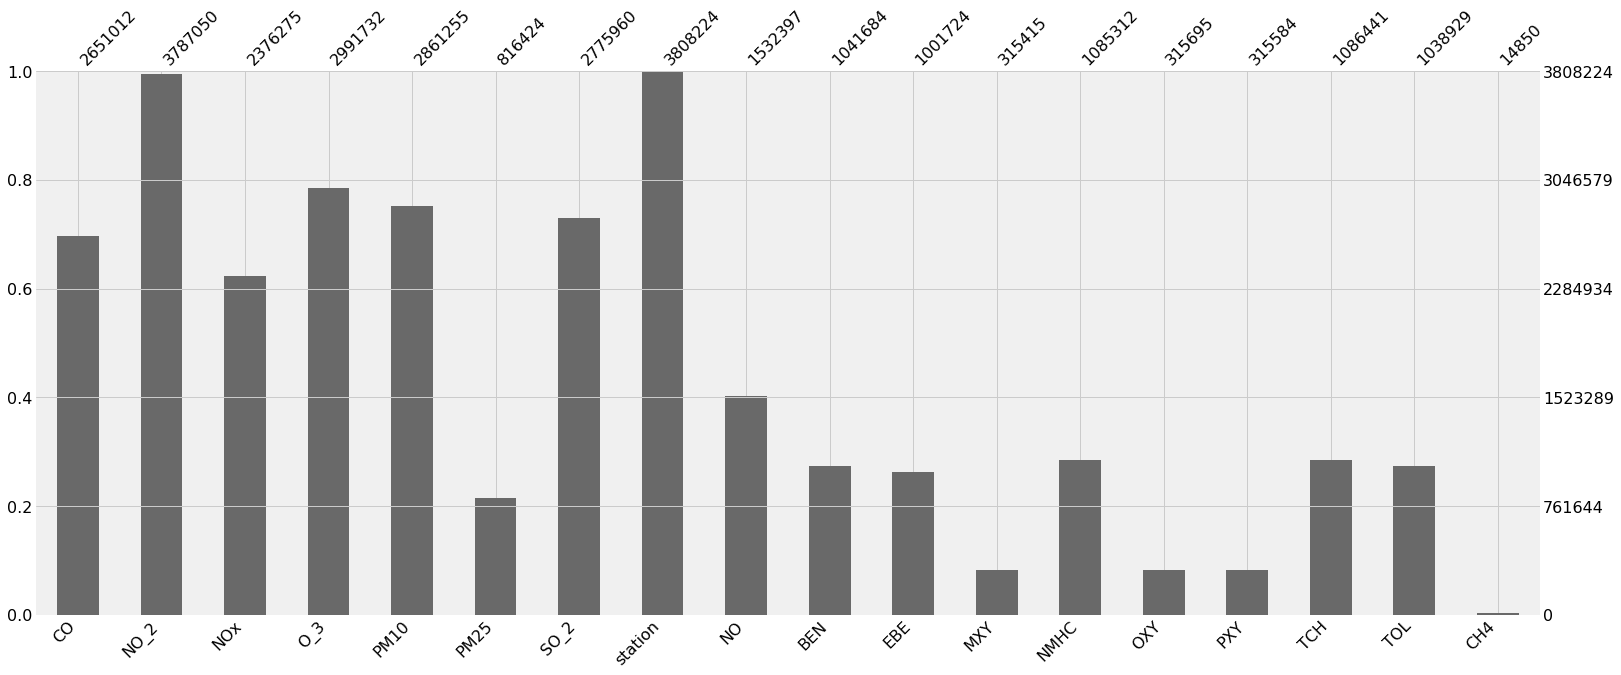

In [137]:
msno.bar(df)
plt.show()

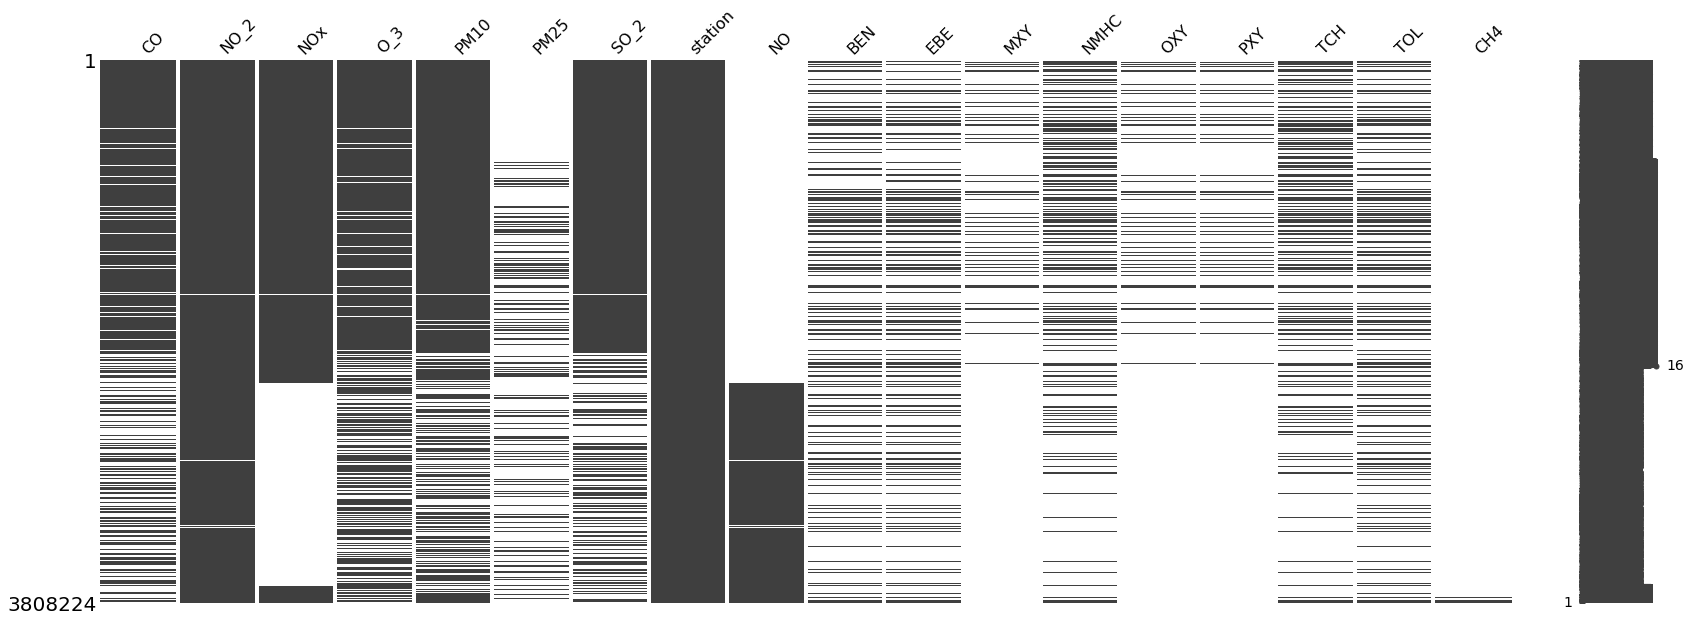

In [138]:
msno.matrix(df)
plt.show()

Для изучения данных предлагаю оставить в данных только 4 самые важные признаки загрязнения, которые могу наносить вред человеку. Тем более все остальные данные, очень сильно разрежены, в них очень много пропусков.

O3 (Ground-level Ozone) - Уровень содержания озона

PM10 (Particulate Matter (soot and dust)) - Микрочастицы сажы и пыли

SO2 (Sulphur Dioxide) - Уровень сернистого газа

NO2 (Nitrogen Dioxide) - Уровень диоксида азота, выбрасывается в атмосферу химическими заводами


In [8]:
master_df = df.drop(columns=['CO', 'NOx', 'PM25', 'NO', 'BEN', 'EBE', 'MXY', 'NMHC', 'OXY', 'PXY', 'TCH', 'TOL', 'CH4'])


Заполним пропуски таким образом, чтобы пропущенные значение равнялись значию, которое было последний раз зарегистрировано. Получается что, пропущенные поля заполняются значениями с предыдущего замера на станции

In [9]:
for i in master_df.station.unique():
    master_df[master_df.station == i] = master_df[master_df.station == i].fillna(method='ffill')

Еще осталось немного пустых значений, это связано с тем, что некоторые наблюдения просто не были завиксированны метеостанцией в какой из дней, поэтому они остались не заполненые. Исправим это недорозумение, просто выкинем их, пустых значений осталось немного, поэтому они не повлияют на исследование.

In [10]:
master_df = master_df.dropna()
master_df_M = master_df.resample('M').mean()
master_df_D = master_df.resample('D').mean()
master_df_Y = master_df.resample('Y').mean()

Почему же я не заполняю пропуски средними, потому что тут важна динамика по часам, поэтому мне показалось, что будет лучше заполнить пропуски именно соседними значениями, на долгосрочные изменения это не повлияет, а в локальном промежутке не будет слишком резких изменений в значениях

## Визуальный анализ данных

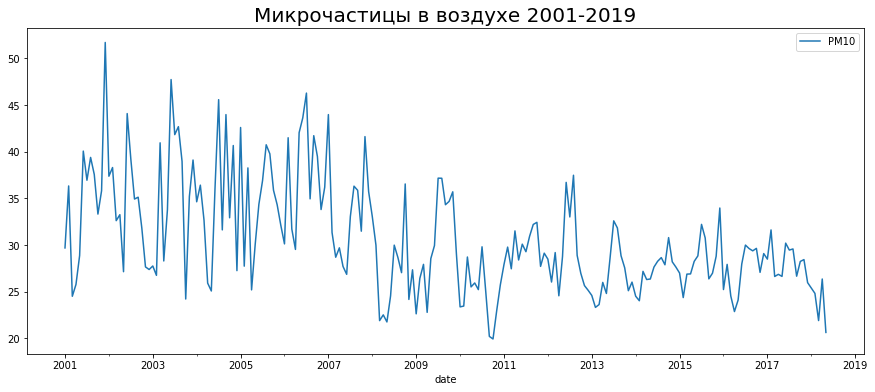

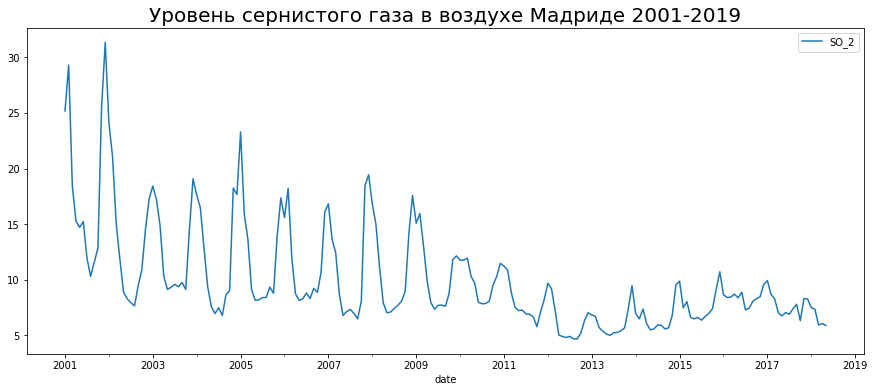

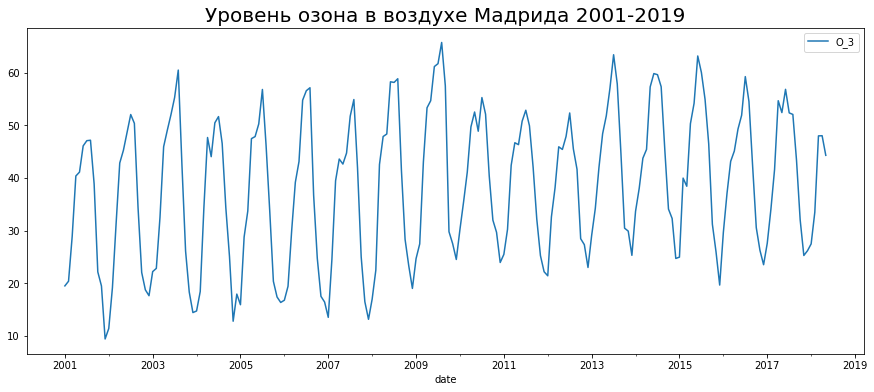

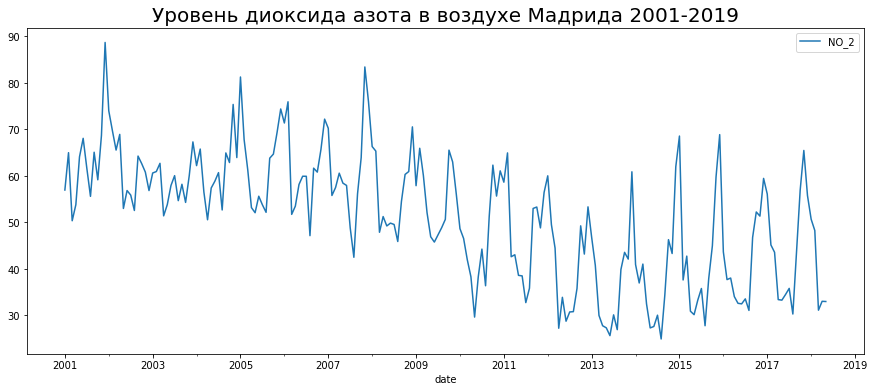

In [38]:
pm10_df = pd.DataFrame(master_df['PM10'].resample('M').mean())
pm10_df.plot(figsize=(15, 6))
plt.title('Микрочастицы в воздухе 2001-2019', fontsize=20)

SO_2_df = pd.DataFrame(master_df['SO_2'].resample('M').mean())
SO_2_df.plot(figsize=(15, 6))
plt.title('Уровень сернистого газа в воздухе Мадриде 2001-2019', fontsize=20)

O_3_df = pd.DataFrame(master_df['O_3'].resample('M').mean())
O_3_df.plot(figsize=(15, 6))
plt.title('Уровень озона в воздухе Мадрида 2001-2019', fontsize=20)

NO_2_df = pd.DataFrame(master_df['NO_2'].resample('M').mean())
NO_2_df.plot(figsize=(15, 6))
plt.title('Уровень диоксида азота в воздухе Мадрида 2001-2019', fontsize=20)
plt.show()

Исследуем компоненты каждого ряда.

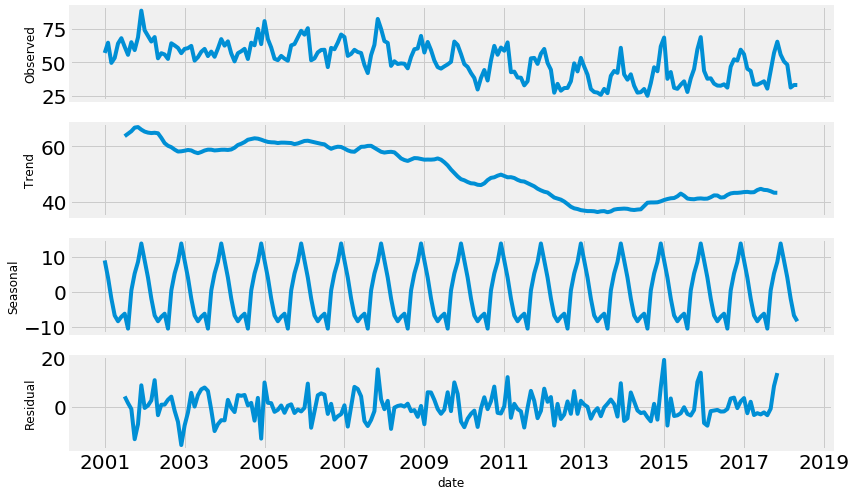

In [205]:
rcParams['figure.figsize'] = 12, 7
NO_2_df = pd.DataFrame(master_df['NO_2'].resample('M').mean())
sm.tsa.seasonal_decompose(NO_2_df).plot()
plt.show()

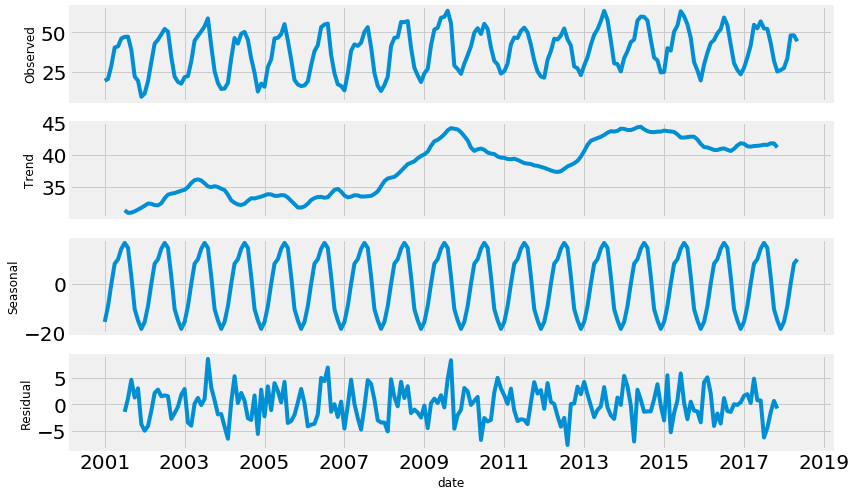

In [207]:
O_3_df = pd.DataFrame(master_df['O_3'].resample('M').mean())
sm.tsa.seasonal_decompose(O_3_df).plot()
plt.show()

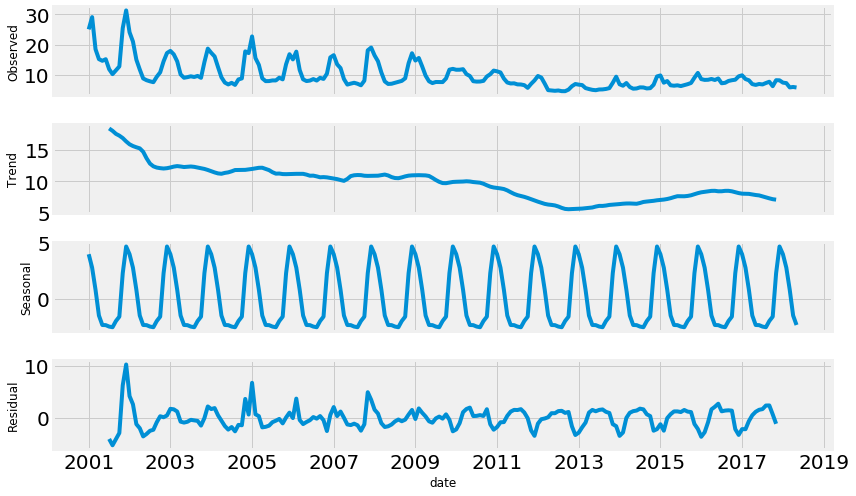

In [208]:
SO_2_df = pd.DataFrame(master_df['SO_2'].resample('M').mean())
sm.tsa.seasonal_decompose(SO_2_df).plot()
plt.show()

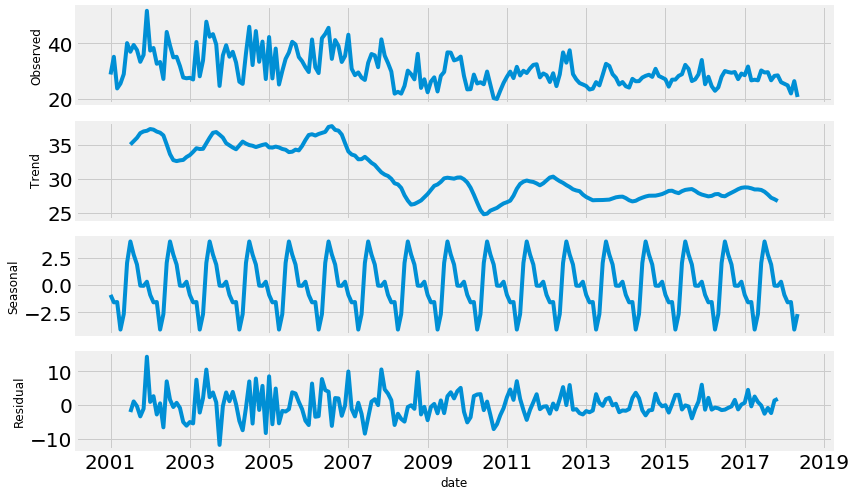

In [209]:
PM10_df = pd.DataFrame(master_df['PM10'].resample('M').mean())
sm.tsa.seasonal_decompose(PM10_df).plot()
plt.show()

Во временных рядах видны ярко выделенные сезонные активности, из графиков видно, что у них переодичность в год. Так же у большиства рядов виден спад показателей, что хорошо. У всех кроме графика уровная озона, у него виден тренд на увеличения уровня.

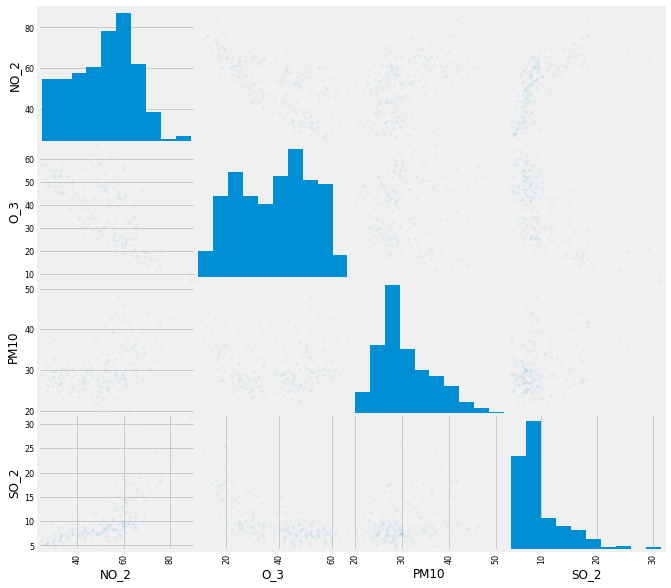

In [151]:
from pandas.plotting import scatter_matrix
scatter_matrix(master_df_M, alpha=0.05, figsize=(10, 10))
plt.show()

In [79]:
master_df_M.corr()

,NO_2,O_3,PM10,SO_2
NO_2,1.000000,-0.690240,0.483028,0.704886
O_3,-0.690240,1.000000,-0.075306,-0.654878
PM10,0.483028,-0.075306,1.000000,0.326038
SO_2,0.704886,-0.654878,0.326038,1.000000


Здесь видна корреляция некоторых параметров, в следующем пунтке посмотрим на сколько она достоверная.

## Проверка статистических гипотез

Проверим гипотизы о коррелиции некоторых величин.
1. Коррелирует ли уровень диоксида озота с уровнем озона.
2. Аналогично проверим гипотезу на коррелицию с уровенем сернистого газа
3. А так же проверим на корреляцию озона с уровнем микрочастиц

Ставим нулевую гипотезу о том, что величины не коррелированы, соответсвенно вторая гипотеза о том, что коррелированы.

H0: r = 0

H1: r <> 0

Чтобы проверять статистические гипотиза для начала следует проверить, что признаки распределены нормально.Для этого воспользуемся критерием Шапиро-Уилка, а так же на всякий случай построим Q-Q график. В критерии Шапиро-Уилка установим уровень значимости в 5%.


In [146]:
print("NO_2", stats.shapiro(master_df_M.NO_2))
print("O_3", stats.shapiro(master_df_M.O_3))
print("SO_2", stats.shapiro(master_df_M.SO_2))
print("PM10", stats.shapiro(master_df_M.PM10))

NO_2 (0.9764732122421265, 0.0014235618291422725)
O_3 (0.9639766812324524, 3.651673614513129e-05)
SO_2 (0.8178026080131531, 6.5949468583122e-15)
PM10 (0.9428924322128296, 2.469107585056918e-07)


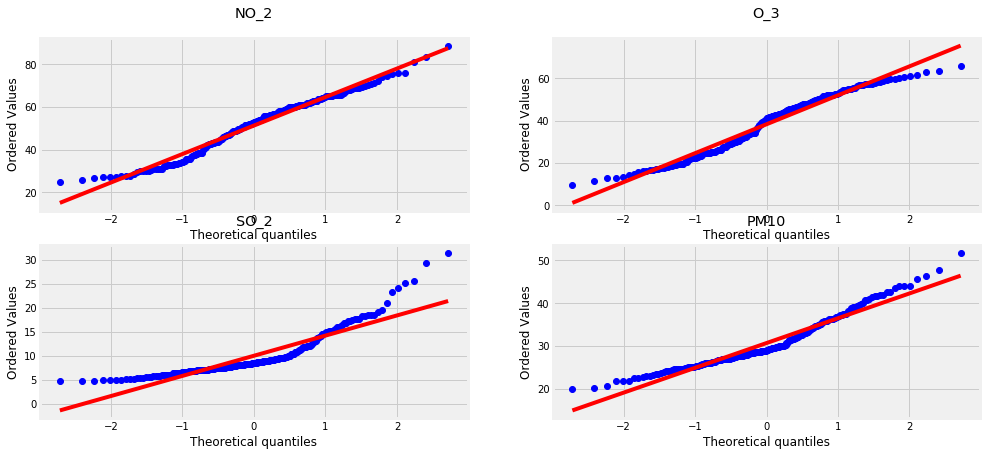

In [142]:
rcParams['axes.titlepad'] = 20 
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(221)

stats.probplot(master_df_M.NO_2, dist = "norm", plot = plt)
ax1.title.set_text('NO_2')

ax2 = fig.add_subplot(222)
stats.probplot(master_df_M.O_3, dist = "norm", plot = plt)
ax2.title.set_text('O_3')

ax3 = fig.add_subplot(223)
stats.probplot(master_df_M.SO_2, dist = "norm", plot = plt)
ax3.title.set_text('SO_2')

ax4 = fig.add_subplot(224)
stats.probplot(master_df_M.PM10, dist = "norm", plot = plt)
ax4.title.set_text('PM10')

plt.show()

На основе полученных наблюдений можно с большой достоверностью сказать, что величины имеют нормальное распределение.

Теперь попробуем применить параметрический критерий Пирсона.
Корреляция Пирсона показывает силу линейной взаимосвязи между елементами.

Чтобы приступать к расчетам коэффициента корреляции Пирсона необходимо выполнение следующих условий:

1. Исследуемые переменные X и Y должны быть распределены нормально.

2. Исследуемые переменные X и Y должны быть измерены в интервальной шкале или шкале отношений.

3. Количество значений в исследуемых переменных X и Y должно быть одинаковым.

Для нашей задачи все три условия выполняются.

Уровень значимости устанавливаем на значении p = 0.05

In [146]:
stats.pearsonr(master_df_M.NO_2, master_df_M.O_3)

(-0.6902396997144977, 6.546218465538953e-31)

In [147]:
stats.pearsonr(master_df_M.NO_2, master_df_M.SO_2)

(0.7048864578324456, 1.0413284894827456e-32)

In [147]:
stats.pearsonr(master_df_M.O_3, master_df_M.PM10)

(-0.0753061602111638, 0.2784983590634729)

Ни один из первых двух критериев не превысил уровень достоверности, поэтому мы отбрасываем нулевую гипотизу.

Таким образом получаем интересные наблюдеия о том, что уровень диоксида озато на прямую коррелирует с уровнем сернистого газа и обратно коррелирует с уровнем озона в воздухе.

С другой стороны было выявленно, что уровень микрочастиц не коррелирует с уровнем озона, потому что критерий не привысил достаточный уровень значимости


Получилась очень интересная зависимость.

Так как мы выяснили, что уровень сернистого газа и диоксида озота коррелирует с уровнем озота, то далее для простоты будем расматривать только уровень озона и микрочастиц.

Проверим являются ли данные временные ряды стационарными. Для этого воспользуемся критерием Дикей-Фуллера и установим порог значимости так же на 5 процентах.

**Задача**: Проверить являются ли временные ряды стационарными.

In [15]:
def adf_test(timeseries, cutoff = 0.05):
    print ('Results of Dickey-Fuller Test:')
    print('Test Statistic < Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    print (dfoutput, '\n')
    
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. Временной ряд стационарен.' % pvalue)
    else:
        print('p-value = %.4f. Временной ряд нестационарен.' % pvalue)

In [12]:
adf_test(O_3_df['O_3'])

Results of Dickey-Fuller Test:
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                  -2.083845
p-value                          0.251060
#Lags Used                      13.000000
Number of Observations Used    195.000000
Critical Value 1%               -3.464337
Critical Value 5%               -2.876479
Critical Value 10%              -2.574733
dtype: float64 

p-value = 0.2511. Временной ряд нестационарен.


In [14]:
adf_test(pm10_df['PM10'])

Results of Dickey-Fuller Test:
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                  -1.720675
p-value                          0.420493
#Lags Used                      10.000000
Number of Observations Used    198.000000
Critical Value 1%               -3.463815
Critical Value 5%               -2.876251
Critical Value 10%              -2.574611
dtype: float64 

p-value = 0.4205. Временной ряд нестационарен.


Критерий показал, что на данный момент ни один из рядов не является стационарным.

В следующем пунтке попробуем их стабилизировать, для того чтобы можно было предсказать временной ряд используя модель SARIMA.

## Предсказание временного ряда

Будем предсказывать показатели для озона.

Для начала сделаем так, чтобы временой ряд стал стационарным.

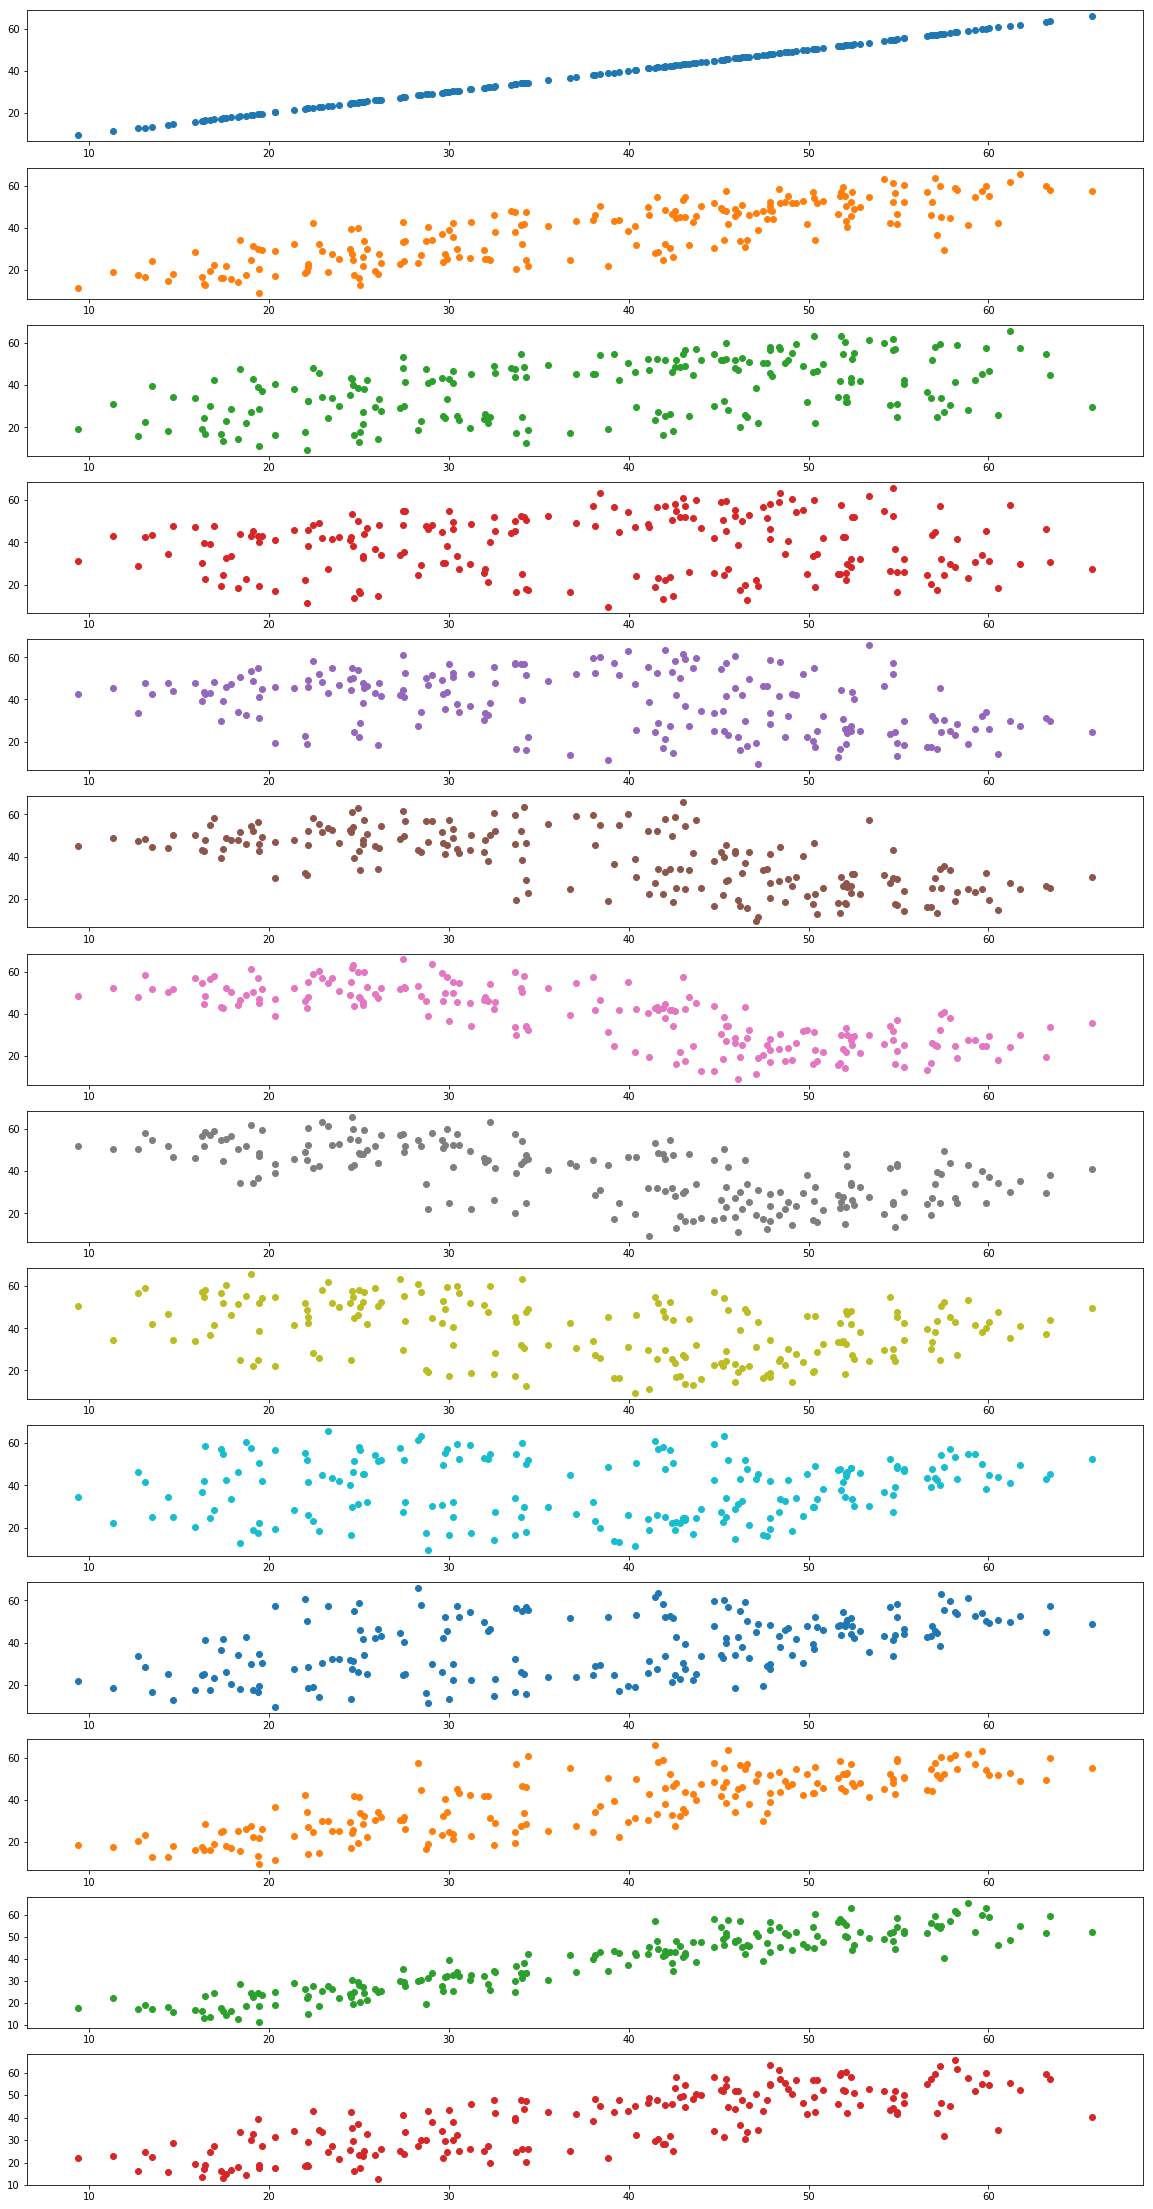

In [28]:
fig, axes = plt.subplots(14,1,figsize = (20,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(master_df_M.O_3, master_df_M.O_3.shift(-k),'o')
plt.show()

Примений преобразование Бокса-Кокса для временного ряда

Box-Cox Lambda Value:  0.934257622074439


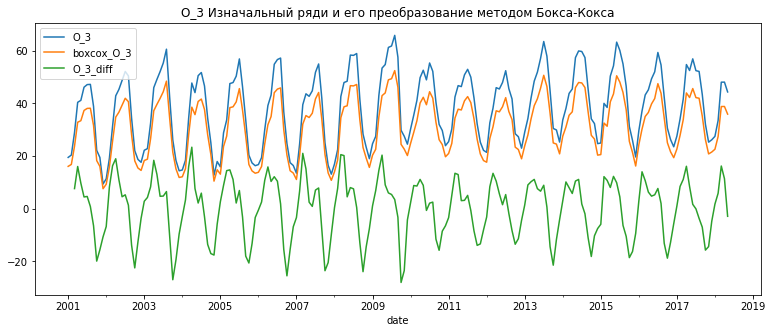

In [62]:
O_3_df['boxcox_O_3'], lamda = boxcox(O_3_df.O_3)
O_3_df.plot(figsize=(13, 5), title='O_3 Изначальный ряди и его преобразование методом Бокса-Кокса')
# plt.show()
print('Box-Cox Lambda Value: ', lamda)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                -8.644857e+00
p-value                        5.304506e-14
#Lags Used                     9.000000e+00
Number of Observations Used    1.980000e+02
Critical Value 1%             -3.463815e+00
Critical Value 5%             -2.876251e+00
Critical Value 10%            -2.574611e+00
dtype: float64 

p-value = 0.0000. Временной ряд стационарен.


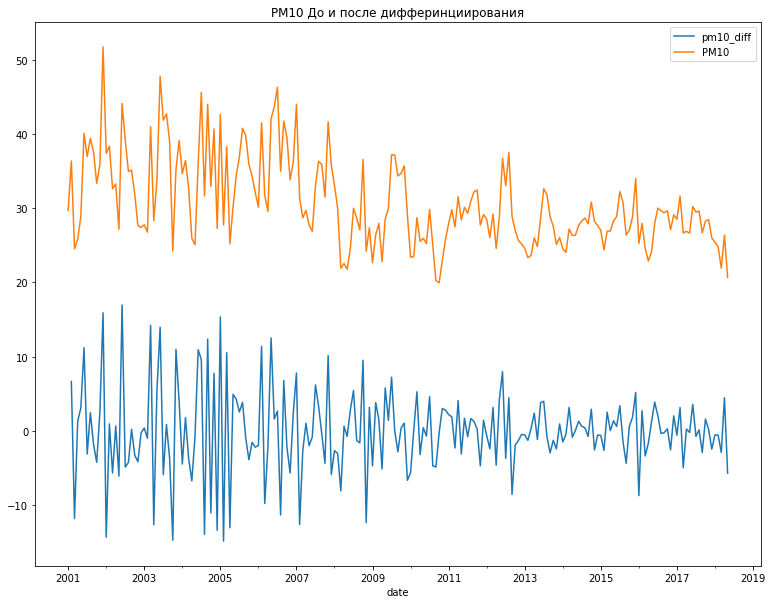

In [69]:
pm10_df['pm10_diff'] = pm10_df['PM10'] - pm10_df['PM10'].shift(1)
pm10_df['pm10_diff'].dropna(inplace=True)
adf_test(pm10_df['pm10_diff'])
pm10_df[['pm10_diff', 'PM10']].plot(figsize=(13, 10), title='PM10 До и после дифферинциирования')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                -8.251217e+00
p-value                        5.384566e-13
#Lags Used                     1.000000e+01
Number of Observations Used    1.960000e+02
Critical Value 1%             -3.464161e+00
Critical Value 5%             -2.876402e+00
Critical Value 10%            -2.574692e+00
dtype: float64 

p-value = 0.0000. Временной ряд стационарен.


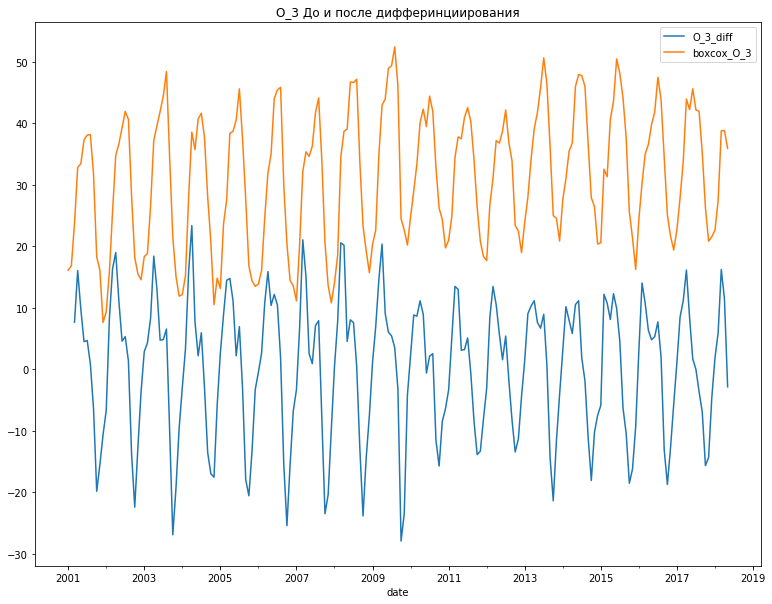

In [63]:
O_3_df['O_3_diff'] = O_3_df['boxcox_O_3'] - O_3_df['boxcox_O_3'].shift(2)
O_3_df.O_3_diff.dropna(inplace=True)
adf_test(O_3_df.O_3_diff)
O_3_df[['O_3_diff', 'boxcox_O_3']].plot(figsize=(13, 10), title='O_3 До и после дифферинциирования')
plt.show()

Проверим еще раз ряд на стационарность. С учетом произведенных преобразований ряд стал стационарным.

Посмотрим на графики авторегрессии и на скользящее среднее.

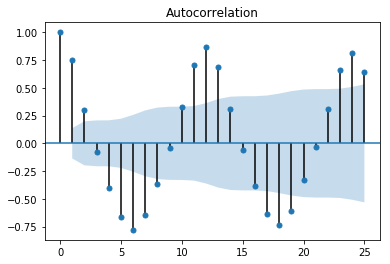

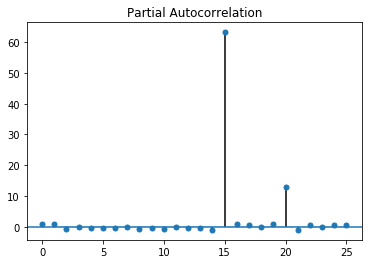

In [64]:
import statsmodels.api as sm
f_acf = sm.graphics.tsa.plot_acf(O_3_df['O_3_diff'], lags=25)
f_pacf = sm.graphics.tsa.plot_pacf(O_3_df['O_3_diff'], lags=25)
plt.show()

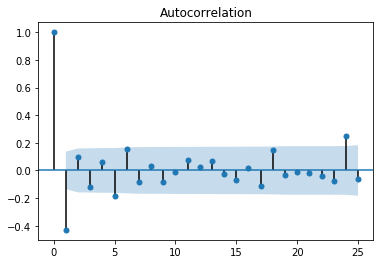

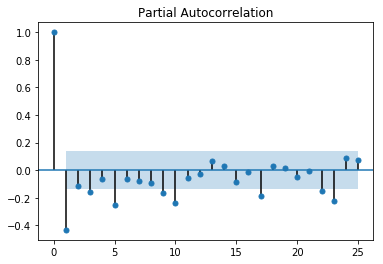

In [65]:
f_acf = sm.graphics.tsa.plot_acf(pm10_df['pm10_diff'], lags=25)
f_pacf = sm.graphics.tsa.plot_pacf(pm10_df['pm10_diff'], lags=25)
plt.show()

In [95]:
def evaluate_model(data, pdq, PDQS, split_date='2018-01-01'):
    train, test = data[:split_date], data[split_date:]
    model = sm.tsa.statespace.SARIMAX(data, order=pdq, seasonal_order=PDQS).fit(disp=-1)
    return {'aic': model.aic}, model


def gridsearch(data, p_range, d_range, q_range, P_range, D_range, Q_range, S, split_date='2018-01-01'):
    models = defaultdict()
    best_score, best_params = float('inf'), None
    parameters = product(p_range, d_range, q_range, P_range, D_range, Q_range, S)
    for param in parameters:
        params = (param[0], param[1], param[2])
        S_params = (param[3], param[4], param[5], param[6])
        try:
            score, model = evaluate_model(data, params, S_params)
            models[str(param)] = score
            if score['aic'] < best_score:
                best_score, best_params, best_model = score['aic'], param, model
        except:
            print('wrong parameters:', param)
            continue
    return best_params, models, best_model

Подберем параметры для модели. Будем предсказывать ряд с 2016 года и по 2020 год.

In [18]:
p_rng = range(0, 6)
d_rng = [2]
q_rng = range(0, 3)
P_rng = range(0, 3)
D_rng = range(0, 3)
Q_rng = range(0, 3)
S = [12]

parameter, models, best_model = gridsearch(O_3_df['boxcox_O_3'],
                                           p_rng, d_rng, q_rng,
                                           P_rng, D_rng, Q_rng, S,
                                           split_date='2016-01-01')

wrong parameters: (0, 2, 0, 0, 2, 1, 12)
wrong parameters: (0, 2, 0, 0, 2, 2, 12)
wrong parameters: (0, 2, 0, 1, 2, 2, 12)
wrong parameters: (0, 2, 1, 0, 2, 0, 12)
wrong parameters: (0, 2, 1, 0, 2, 1, 12)
wrong parameters: (0, 2, 1, 0, 2, 2, 12)
wrong parameters: (0, 2, 1, 1, 2, 0, 12)
wrong parameters: (0, 2, 1, 1, 2, 1, 12)
wrong parameters: (0, 2, 1, 1, 2, 2, 12)
wrong parameters: (0, 2, 1, 2, 0, 2, 12)
wrong parameters: (0, 2, 1, 2, 2, 0, 12)
wrong parameters: (0, 2, 1, 2, 2, 1, 12)
wrong parameters: (0, 2, 1, 2, 2, 2, 12)
wrong parameters: (0, 2, 2, 0, 2, 1, 12)
wrong parameters: (0, 2, 2, 0, 2, 2, 12)
wrong parameters: (0, 2, 2, 1, 2, 2, 12)
wrong parameters: (1, 2, 0, 0, 2, 1, 12)
wrong parameters: (1, 2, 0, 0, 2, 2, 12)
wrong parameters: (1, 2, 0, 1, 2, 2, 12)
wrong parameters: (1, 2, 1, 0, 2, 1, 12)
wrong parameters: (1, 2, 1, 0, 2, 2, 12)
wrong parameters: (1, 2, 1, 1, 2, 2, 12)
wrong parameters: (1, 2, 2, 0, 1, 0, 12)
wrong parameters: (1, 2, 2, 0, 1, 1, 12)
wrong parameters

In [19]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                         boxcox_O_3   No. Observations:                  209
Model:             SARIMAX(4, 2, 2)x(0, 1, 1, 12)   Log Likelihood                -497.549
Date:                            Sun, 12 May 2019   AIC                           1011.097
Time:                                    15:04:02   BIC                           1037.281
Sample:                                01-31-2001   HQIC                          1021.699
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3274      0.144      2.277      0.023       0.046       0.609
ar.L2          0.0711      0.100   

In [20]:
split_date = '2016-01-01'
data = O_3_df['O_3']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
prediction = best_model.predict(start = train.shape[0], end = train.shape[0] + test_len + 12)

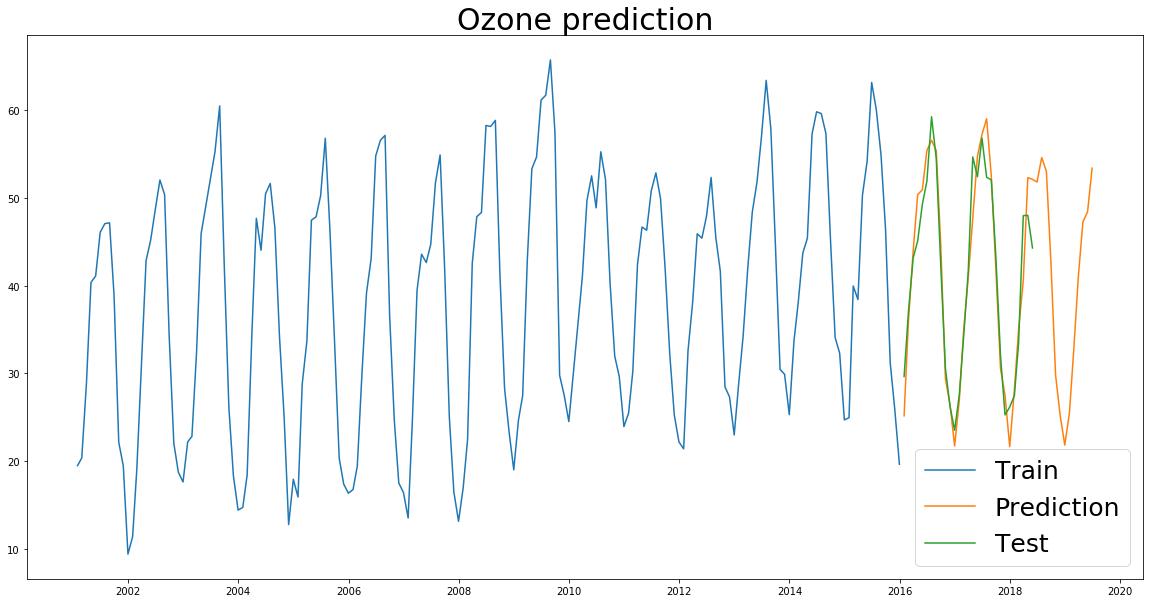

In [21]:
prediction_real = inv_boxcox(prediction, lamda)
plt.figure(figsize=(20, 10))
plt.title('Ozone prediction', fontsize=30)
plt.plot(train, label='Train')
plt.plot(prediction_real, label='Prediction')
plt.plot(test, label='Test')

plt.legend(fontsize= 25)
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(test, prediction[:len(test)]))
print(rms)

8.286903997443062


In [96]:
p_rng = range(0, 6)
d_rng = [1]
q_rng = range(0, 3)
P_rng = range(0, 3)
D_rng = range(0, 3)
Q_rng = range(0, 3)
S = [12]

parameter, models, best_model = gridsearch(pm10_df['PM10'],
                                           p_rng, d_rng, q_rng,
                                           P_rng, D_rng, Q_rng, S,
                                           split_date='2016-01-01')

wrong parameters: (0, 1, 0, 0, 2, 1, 12)
wrong parameters: (0, 1, 1, 0, 2, 1, 12)
wrong parameters: (0, 1, 2, 0, 2, 1, 12)
wrong parameters: (1, 1, 0, 0, 2, 1, 12)
wrong parameters: (1, 1, 1, 0, 2, 1, 12)
wrong parameters: (1, 1, 2, 0, 2, 1, 12)
wrong parameters: (2, 1, 0, 0, 2, 1, 12)
wrong parameters: (2, 1, 1, 0, 0, 0, 12)
wrong parameters: (2, 1, 1, 0, 0, 1, 12)
wrong parameters: (2, 1, 1, 0, 0, 2, 12)
wrong parameters: (2, 1, 1, 0, 2, 1, 12)
wrong parameters: (2, 1, 1, 1, 0, 0, 12)
wrong parameters: (2, 1, 1, 1, 0, 1, 12)
wrong parameters: (2, 1, 1, 1, 0, 2, 12)
wrong parameters: (2, 1, 1, 2, 0, 0, 12)
wrong parameters: (2, 1, 1, 2, 0, 1, 12)
wrong parameters: (2, 1, 1, 2, 0, 2, 12)
wrong parameters: (2, 1, 2, 0, 1, 0, 12)
wrong parameters: (2, 1, 2, 0, 1, 1, 12)
wrong parameters: (2, 1, 2, 0, 1, 2, 12)
wrong parameters: (2, 1, 2, 0, 2, 0, 12)
wrong parameters: (2, 1, 2, 0, 2, 1, 12)
wrong parameters: (2, 1, 2, 0, 2, 2, 12)
wrong parameters: (2, 1, 2, 1, 1, 0, 12)
wrong parameters

In [97]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                               PM10   No. Observations:                  209
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -578.304
Date:                            Sun, 12 May 2019   AIC                           1170.608
Time:                                    16:14:51   BIC                           1193.555
Sample:                                01-31-2001   HQIC                          1179.898
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2332      0.068      3.446      0.001       0.101       0.366
ar.L2          0.2932      0.079   

In [120]:
split_date = '2017-01-01'
data = pm10_df['PM10']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
prediction = best_model.predict(start = train.shape[0], end = train.shape[0] + test_len + 24)

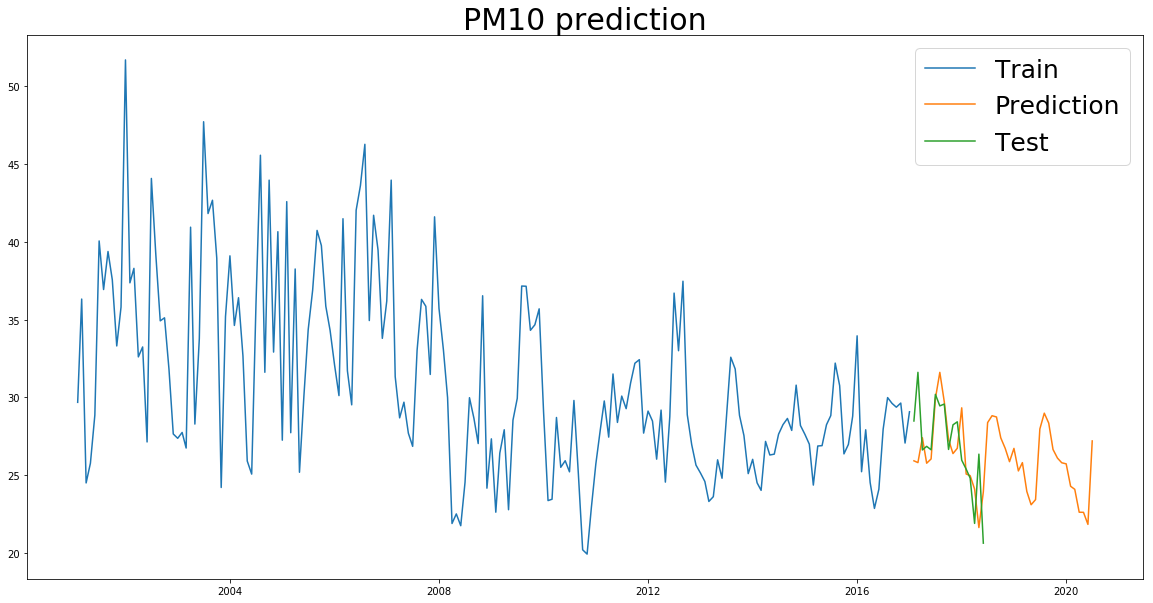

In [121]:
plt.figure(figsize=(20, 10))
plt.title('PM10 prediction', fontsize=30)
plt.plot(train, label='Train')
plt.plot(prediction, label='Prediction')
plt.plot(test, label='Test')

plt.legend(fontsize= 25)
plt.show()

In [122]:
rms = np.sqrt(mean_squared_error(test, prediction[:len(test)]))
print(rms)

2.464801335674201


## Выводы

Построен прогноз уровня загрязнения в городе Мадрид для показателей озона и микро частиц.

В целом наблюдается спад опасных частиц, кроме озона, который немного из года в год растет.

Была найдена интересная корреляции опасных веществ между собой. Я думаю, это связано с выбросами в атмосферу предприятий и так как идет политика очищения воздуха, то и заводов, которые бы выбрасывали их в атмосферу, стало меньшех.

Построенная модель SARIMA показала хорошую точность для обоих временных рядов. 